<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%205/Laboratorio_V_Soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




## Objetivos

*   Analizar la estructura de una Red Neuronal.
*   Construir un modelo a través de `Keras` y `TensorFlow`.
*   Realizar la búsqueda de hiperparámetros para ajustar una Red Neuronal.



## Taller
## Segundo Problema


Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías.

Se propone como ejercicio realizar ***un clasificador utilizando un MLP*** para la solución de este problema.


### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
import nltk
nltk.download()

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=bb3f59f5c9b2526f0385d0c581540f7540c21740d6a4660fe1f517aea5d9a013
  Stored in directory: /tmp/pip-ephem-wheel-cache-k4kvsg_p/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
import pandas as pd
import numpy as np
import os
import os.path as osp
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
!git clone https://github.com/jcestevezc/Machine-Learning-Techniques.git

fatal: destination path 'Machine-Learning-Techniques' already exists and is not an empty directory.


In [ ]:
datos = pd.DataFrame(columns=['Categoria','Texto'])

path = osp.join('Machine-Learning-Techniques','Laboratorio 5','Punto 2','Noticias BBC')
categorias = os.listdir(path)
for cat in categorias:
    if cat.startswith('.'): continue
    articulos = os.listdir(osp.join(path,cat))
    for x in articulos:
        texto = open(osp.join(path,cat,x),'r',encoding='unicode_escape').read()
        
        datos = datos.append({'Categoria':cat,'Texto':texto},ignore_index=True)

print(datos.shape)

display(datos.head())

(2225, 2)


,Categoria,Texto
0,tech,US state acts to stop 'spammers'\n\nUS state T...
1,tech,US woman sues over ink cartridges\n\nA US woma...
2,tech,Speech takes on search engines\n\nA Scottish f...
3,tech,Attack prompts Bush site block\n\nThe official...
4,tech,US top of supercomputing charts\n\nThe US has ...


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [ ]:
datos['Conteo'] = [len(x) for x in datos['Texto']]
datos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in datos['Texto']]
datos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in datos['Texto']]
datos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in datos['Texto']]

ProfileReport(datos)

### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [ ]:
datos['words'] = datos['Texto'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [ ]:
datos['words'] = datos['words'].apply(word_tokenize)
datos['words'] = datos['words'].apply(preproccesing) #Aplica la eliminación del ruido
datos.head()

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,tech,US state acts to stop 'spammers'\n\nUS state T...,2626,the,14,1,"[us, state, acts, stop, spammers, us, state, t..."
1,tech,US woman sues over ink cartridges\n\nA US woma...,1532,the,14,1,"[us, woman, sues, ink, cartridges, us, woman, ..."
2,tech,Speech takes on search engines\n\nA Scottish f...,2982,the,17,1,"[speech, takes, search, engines, scottish, fir..."
3,tech,Attack prompts Bush site block\n\nThe official...,3485,the,16,1,"[attack, prompts, bush, site, block, official,..."
4,tech,US top of supercomputing charts\n\nThe US has ...,2285,the,19,1,"[us, top, supercomputing, charts, us, pushed, ..."


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

datos['words'] = datos['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
datos.head()

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,tech,US state acts to stop 'spammers'\n\nUS state T...,2626,the,14,1,"[us, stat, act, stop, spam, us, stat, texa, fi..."
1,tech,US woman sues over ink cartridges\n\nA US woma...,1532,the,14,1,"[us, wom, sue, ink, cartridg, us, wom, suing, ..."
2,tech,Speech takes on search engines\n\nA Scottish f...,2982,the,17,1,"[speech, tak, search, engin, scot, firm, look,..."
3,tech,Attack prompts Bush site block\n\nThe official...,3485,the,16,1,"[attack, prompt, bush, sit, block, off, reelec..."
4,tech,US top of supercomputing charts\n\nThe US has ...,2285,the,19,1,"[us, top, supercomput, chart, us, push, jap, t..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [ ]:
datos['words'] = datos['words'].apply(lambda x: ' '.join(map(str, x)))
datos

,Categoria,Texto,Conteo,Moda,Max,Min,words
0,tech,US state acts to stop 'spammers'\n\nUS state T...,2626,the,14,1,us stat act stop spam us stat texa fil lawsuit...
1,tech,US woman sues over ink cartridges\n\nA US woma...,1532,the,14,1,us wom sue ink cartridg us wom suing hewlet pa...
2,tech,Speech takes on search engines\n\nA Scottish f...,2982,the,17,1,speech tak search engin scot firm look attract...
3,tech,Attack prompts Bush site block\n\nThe official...,3485,the,16,1,attack prompt bush sit block off reelect sit p...
4,tech,US top of supercomputing charts\n\nThe US has ...,2285,the,19,1,us top supercomput chart us push jap top super...
...,...,...,...,...,...,...,...
2220,politics,Tories 'would cut number of MPs'\n\nThe Conser...,2137,the,15,1,tory would cut numb mps conserv party would cu...
2221,politics,Blair dismisses quit claim report\n\nTony Blai...,3634,the,16,1,blair dismiss quit claim report tony blair dis...
2222,politics,Crisis 'ahead in social sciences'\n\nA nationa...,1505,the,13,1,cris ahead soc sci nat body design tackl skil ...
2223,politics,Howard unveils Tory asylum plans\n\nTory plans...,3721,the,16,1,howard unveil tory asyl plan tory plan cut imm...


Para este caso, la decisión que se toma para poder predecir los datos es tener una columna con una transformación de 1 a 5 para las categorías a predecir. Para guardar el orden y realizar después la transformación, se utiliza la clase `LabelEncoder`.

In [ ]:
X, y = datos['words'],datos['Categoria']
print(y)
le = LabelEncoder()
y = le.fit_transform(y)
y

0           tech
1           tech
2           tech
3           tech
4           tech
          ...   
2220    politics
2221    politics
2222    politics
2223    politics
2224    politics
Name: Categoria, Length: 2225, dtype: object


array([4, 4, 4, ..., 2, 2, 2])

### 4. Modelamiento

Para obtener el mejor modelo, se realizan 30 iteraciones aleatorias entre los parámetros para obtener un buen modelo para predecir. Entre los hiperparámetros a buscar se realizará el número de capas, el número de neuronas en cada capa, la activación de la capa oculta, el porcentaje de Dropout y la transformación a utilizar para los textos. 

In [ ]:
def entrenarRed(nn1 = 512, nn2 = 100, n_layers= 2, dropout = 0.1, activacion_oculta = 'relu'):
    clf = Sequential(name='Mi_Red')
    #input = len(pipe['transformacion'].get_feature_names())
    output = 2
    first = True
    for i in range(n_layers):
        if first:
            clf.add(Dense(nn1, activation=activacion_oculta, name='Capa_Oculta__{0}'.format(nn1)))
            first = False
        else:
            clf.add(Dense(nn2, activation=activacion_oculta, name = 'Capa_Oculta_{0}__{1}'.format(i,nn2)))
    
    clf.add(Dropout(dropout,name='Dropout_{0}'.format(dropout)))
    clf.add(Dense(5, activation='sigmoid', name= 'Capa_Salida'))
    clf.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenarRed, epochs=20, batch_size=10, verbose=1,shuffle = True)


In [ ]:
class toArray():
    def __init__(self):
        return

    def transform(self, X, **transform_params):
        global cont
        print('------------------------',int(cont),'------------------------')
        cont = cont + 0.5
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self

Con la función definida, se construye un pipeline para que el modelo solo tenga que recibir el texto que tiene que analizar, realice la transformación correspondiente y pueda realizar la clasificación con la mejor red encontrada.

In [ ]:
cont = 1

pipe = Pipeline([('transformacion',TfidfVectorizer()),
                 ('matriz',toArray()),
                  ('red_neuronal',modelCV)])

param_grid = dict(transformacion=[TfidfVectorizer(),CountVectorizer()],
                  red_neuronal__nn1 = [512, 256, 128],
                  red_neuronal__nn2 = [512, 256, 128],
                  red_neuronal__n_layers = [1,2],
                  red_neuronal__dropout = [0.1,0.2,0.3],
                  red_neuronal__activacion_oculta = ['relu','sigmoid','tanh']
                  )

grid = RandomizedSearchCV(pipe,param_grid,scoring='accuracy',verbose=1,cv = 5,n_iter=30,random_state=20)


Se separan los textos y las categorias ya transformadas.

In [ ]:
Xtext_train, Xtext_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

grid.fit(Xtext_train,y_train)

best_model = grid.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Se han truncado las últimas 5000 líneas del flujo de salida.
143/143 [==============================] - 2s 13ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 17/20
143/143 [==============================] - 2s 13ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 18/20
143/143 [==============================] - 2s 13ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 19/20
143/143 [==============================] - 2s 13ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 20/20
143/143 [==============================] - 2s 13ms/step - loss: 0.0091 - accuracy: 1.0000
------------------------ 34 ------------------------
36/36 [==============================] - 0s 5ms/step
------------------------ 35 ------------------------
Epoch 1/20
143/143 [==============================] - 2s 13ms/step - loss: 0.5956 - accuracy: 0.8848
Epoch 2/20
143/143 [==============================] - 2s 13ms/step - loss: 0.1670 - accuracy: 0.9881
Epoch 3/20
143/143 [==============================] - 2s 12ms/step - loss: 0.098

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 173.9min finished


------------------------ 151 ------------------------
Epoch 1/20
178/178 [==============================] - 5s 27ms/step - loss: 0.5573 - accuracy: 0.8843
Epoch 2/20
178/178 [==============================] - 5s 28ms/step - loss: 0.1424 - accuracy: 0.9893
Epoch 3/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0766 - accuracy: 0.9961
Epoch 4/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0480 - accuracy: 0.9994
Epoch 5/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0343 - accuracy: 1.0000
Epoch 6/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0265 - accuracy: 1.0000
Epoch 7/20
178/178 [==============================] - 5s 28ms/step - loss: 0.0222 - accuracy: 0.9994
Epoch 8/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 9/20
178/178 [==============================] - 5s 27ms/step - loss: 0.0157 - accuracy: 1.0000
Epoch 10/20
178/178 [================

In [ ]:
print(best_model)
best_model['red_neuronal'].model.summary()

Pipeline(memory=None,
         steps=[('transformacion',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('matriz', <__main__.toArray object at 0x7f38159cf748>),
                ('red_neuronal',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f380193c278>)],
         verbose=False)
Model: "Mi_Red"
_________________________________________________________________
Layer (type)          

### **5. Predicción**

In [ ]:
y_pred_text = best_model.predict(Xtext_test)
y_pred_text

------------------------ 151 ------------------------
45/45 [==============================] - 0s 10ms/step


array([4, 1, 3, 3, 1, 0, 2, 4, 0, 0, 0, 4, 2, 2, 3, 3, 3, 3, 4, 1, 2, 2,
       0, 0, 4, 3, 1, 1, 3, 2, 3, 4, 0, 2, 4, 3, 0, 2, 0, 3, 3, 2, 0, 4,
       0, 4, 4, 2, 2, 0, 4, 0, 3, 2, 1, 1, 2, 3, 4, 1, 3, 0, 2, 0, 1, 1,
       0, 3, 3, 4, 4, 3, 3, 0, 4, 2, 3, 2, 3, 3, 3, 0, 0, 3, 3, 0, 2, 2,
       1, 3, 2, 1, 4, 3, 3, 0, 4, 2, 3, 2, 3, 3, 3, 2, 0, 2, 1, 3, 4, 4,
       2, 1, 1, 2, 2, 0, 1, 0, 1, 4, 3, 1, 4, 0, 1, 4, 3, 0, 2, 1, 1, 2,
       1, 3, 4, 2, 0, 3, 1, 4, 2, 0, 3, 3, 0, 3, 0, 3, 3, 4, 0, 4, 0, 1,
       4, 3, 1, 0, 2, 3, 1, 0, 3, 0, 0, 0, 4, 2, 2, 1, 4, 4, 2, 1, 4, 4,
       4, 3, 2, 1, 2, 0, 2, 1, 4, 3, 2, 3, 0, 0, 3, 3, 1, 3, 1, 2, 2, 2,
       1, 0, 0, 2, 4, 4, 3, 3, 4, 2, 0, 0, 3, 3, 3, 2, 0, 3, 3, 4, 3, 0,
       0, 2, 2, 4, 3, 0, 4, 4, 3, 3, 3, 2, 3, 2, 1, 1, 3, 0, 3, 3, 4, 4,
       4, 2, 2, 1, 1, 3, 0, 0, 0, 2, 1, 2, 4, 1, 4, 1, 4, 4, 1, 3, 2, 0,
       0, 0, 3, 0, 2, 2, 2, 0, 1, 3, 3, 2, 4, 2, 1, 0, 3, 2, 0, 0, 1, 2,
       4, 3, 0, 4, 1, 3, 0, 4, 1, 3, 0, 3, 0, 0, 0,

### **6. Validación**

In [ ]:
print('Reporte para el modelo entonado')
print(classification_report(y_test, y_pred_text, target_names=le.classes_))

Reporte para el modelo entonado
               precision    recall  f1-score   support

     business       0.96      0.96      0.96        91
entertainment       0.97      0.99      0.98        73
     politics       0.95      0.97      0.96        87
        sport       1.00      0.99      1.00       113
         tech       1.00      0.99      0.99        81

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



Text(54.26, 0.5, 'predicted label')

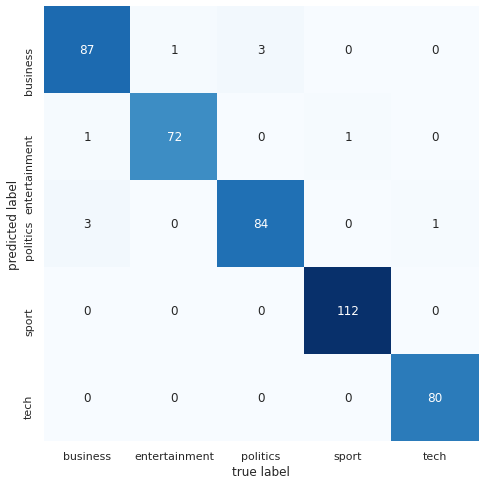

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred_text)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('true label')
plt.ylabel('predicted label')

Tambien se pueden salvar todos los modelos a disco, que pueden ser utilizados y cargados después.

In [ ]:
from keras.models import load_model
import joblib

# Primero se salva el modelo de Keras:
best_model.named_steps['red_neuronal'].model.save('keras_model.h5')

# Luego se elimina el modelo:
best_model.named_steps['red_neuronal'].model = None

# Y por último, se salva el pipeline:
joblib.dump(best_model, 'sklearn_pipeline.pkl')

joblib.dump(grid,'grid_search.pkl')

['sklearn_pipeline.pkl']

In [ ]:
# Primero se carga el pipeline:
pipeline = joblib.load('sklearn_pipeline.pkl')

# Después se carga el modelo y se asigna al modelo vacío:
pipeline.named_steps['red_neuronal'].model = tf.keras.models.load_model('keras_model.h5')

y_pred = pipeline.predict(Xtext_test)

print('Reporte para el modelo entonado')
print(classification_report(y_test, y_pred, target_names=le.classes_))

------------------------ 152 ------------------------
45/45 [==============================] - 0s 10ms/step
Reporte para el modelo entonado
               precision    recall  f1-score   support

     business       0.96      0.96      0.96        91
entertainment       0.97      0.99      0.98        73
     politics       0.95      0.97      0.96        87
        sport       1.00      0.99      1.00       113
         tech       1.00      0.99      0.99        81

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



In [ ]:
# Primero se carga el pipeline:
grid_p = joblib.load('grid_search.pkl')

pd.DataFrame(grid_p.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_transformacion,param_red_neuronal__nn2,param_red_neuronal__nn1,param_red_neuronal__n_layers,param_red_neuronal__dropout,param_red_neuronal__activacion_oculta,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,129.301178,1.744154,0.878279,0.038600,"CountVectorizer(analyzer='word', binary=False,...",256,512,2,0.3,relu,{'transformacion': CountVectorizer(analyzer='w...,0.969101,0.955056,0.969101,0.971910,0.969101,0.966854,0.005998,11
1,39.156780,0.667732,0.438593,0.046228,"CountVectorizer(analyzer='word', binary=False,...",256,128,2,0.3,tanh,{'transformacion': CountVectorizer(analyzer='w...,0.969101,0.969101,0.971910,0.977528,0.969101,0.971348,0.003276,4
2,70.116318,1.141261,0.577868,0.047257,"CountVectorizer(analyzer='word', binary=False,...",256,256,1,0.1,tanh,{'transformacion': CountVectorizer(analyzer='w...,0.966292,0.966292,0.971910,0.974719,0.977528,0.971348,0.004494,2
3,115.448929,2.094691,0.767284,0.016966,"TfidfVectorizer(analyzer='word', binary=False,...",256,512,1,0.3,tanh,{'transformacion': TfidfVectorizer(analyzer='w...,0.522472,0.466292,0.474719,0.432584,0.384831,0.456180,0.045799,21
4,39.481579,0.490280,0.417404,0.040778,"CountVectorizer(analyzer='word', binary=False,...",512,128,2,0.2,sigmoid,{'transformacion': CountVectorizer(analyzer='w...,0.935393,0.949438,0.960674,0.957865,0.957865,0.952247,0.009231,18
5,34.970809,0.625959,0.400887,0.056460,"TfidfVectorizer(analyzer='word', binary=False,...",256,128,2,0.3,relu,{'transformacion': TfidfVectorizer(analyzer='w...,0.443820,0.435393,0.233146,0.283708,0.252809,0.329775,0.091153,25
6,37.623947,0.572977,0.382422,0.010768,"CountVectorizer(analyzer='word', binary=False,...",512,128,1,0.2,tanh,{'transformacion': CountVectorizer(analyzer='w...,0.963483,0.966292,0.971910,0.974719,0.977528,0.970787,0.005210,5
7,68.159630,2.121885,0.589597,0.034498,"CountVectorizer(analyzer='word', binary=False,...",512,256,2,0.2,relu,{'transformacion': CountVectorizer(analyzer='w...,0.963483,0.955056,0.960674,0.966292,0.980337,0.965169,0.008446,14
8,71.688360,3.723830,0.857324,0.549093,"CountVectorizer(analyzer='word', binary=False,...",256,256,2,0.2,relu,{'transformacion': CountVectorizer(analyzer='w...,0.957865,0.963483,0.969101,0.971910,0.971910,0.966854,0.005447,11
9,37.964824,0.728620,0.392468,0.008178,"CountVectorizer(analyzer='word', binary=False,...",256,128,2,0.2,sigmoid,{'transformacion': CountVectorizer(analyzer='w...,0.952247,0.963483,0.963483,0.957865,0.969101,0.961236,0.005729,16
